**STROKE PRECISION**

In [842]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

from sklearn.metrics import f1_score, recall_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import metrics
from skopt import BayesSearchCV
from skopt.space import Real, Integer



import warnings
warnings.filterwarnings('ignore')

1) id: unique identifier
2) gender: "Male", "Female", or "Other"
3) age: patient's age
4) hypertension: 0 if the patient does not have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient does not have heart disease, 1 if the patient has heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_job", "Never_worked", "Private", or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes", or "Unknown"
12) stroke: 1 if the patient had a stroke, or 0 if not (target)

In [843]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


****
EDA
****

Let's conduct an initial data analysis.


In [844]:
# General information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


В датасете 7 вещественных колонок и 5 категориальных. Есть пропуски в одной колонке

In [845]:
# Statistics for numerical and categorical columns
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


In [846]:
data.describe(include=object)

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


In [847]:
print('The percentage of people with hypertension:', round(len(data[data['hypertension'] == 1]) * 100 / len(data), 3), '%')
print('The percentage of people with heart disease!:', round(len(data[data['heart_disease'] == 1]) * 100 / len(data), 3), '%')
print('The percentage of people with stroke:', round(len(data[data['stroke'] == 1]) * 100 / len(data), 3), '%')



The percentage of people with hypertension: 9.746 %
The percentage of people with heart disease!: 5.401 %
The percentage of people with stroke: 4.873 %


In [848]:
# Class distribution in the target variable
data['stroke'].value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [849]:
data['work_type'].value_counts()

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

In [850]:
data['smoking_status'].value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

Let's go through each column:
1. age: Average age is 43 years, with a standard deviation of 22 years. There are anomalies.
2. gender: 3 unique values, majority are female.
3. hypertension: Hypertension is present in 10% of people.
4. heart_disease: Heart disease is present in 5% of people.
5. ever_married: 2 unique values, majority are married.
6. work_type: 5 unique values, majority are in Private sector.
7. Residence_type: 2 unique values, majority live in urban areas.
8. avg_glucose_level: Average glucose level is around 106 mg/dl. There are anomalies in the column.
9. bmi: Average body mass index is 29. There are anomalies in the column.
10. smoking_status: 4 unique values, majority do not smoke. However, almost as many values are unknown.
11. stroke: Stroke occurred in 4.9% of people.

**The visual data analysis.**

Let's start with a correlation analysis


In [851]:
num_cols = data.select_dtypes(include=['int', 'float'])
num_cols.drop('id', axis=1, inplace=True)
cat_cols = data.select_dtypes(include=object)



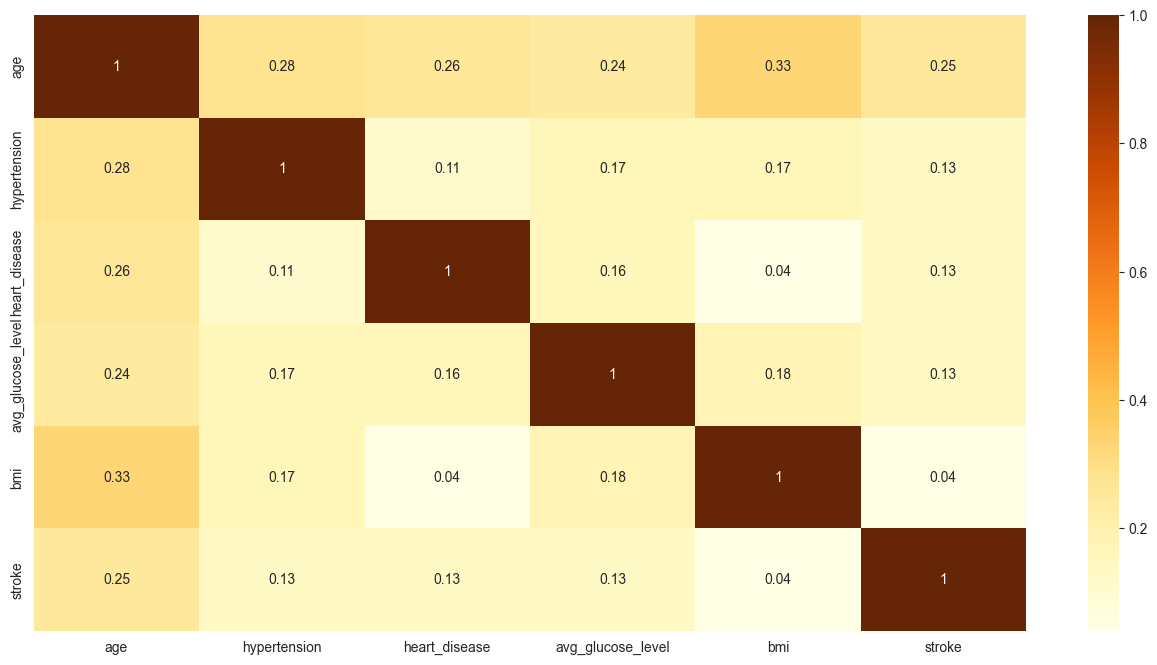

In [852]:
#  We will evaluate the numerical features using the Pearson correlation coefficient
corr = num_cols.corr().round(2)
plt.figure(figsize=(16, 8))
sns.heatmap(corr, annot = True, cmap = 'YlOrBr');

<Axes: >

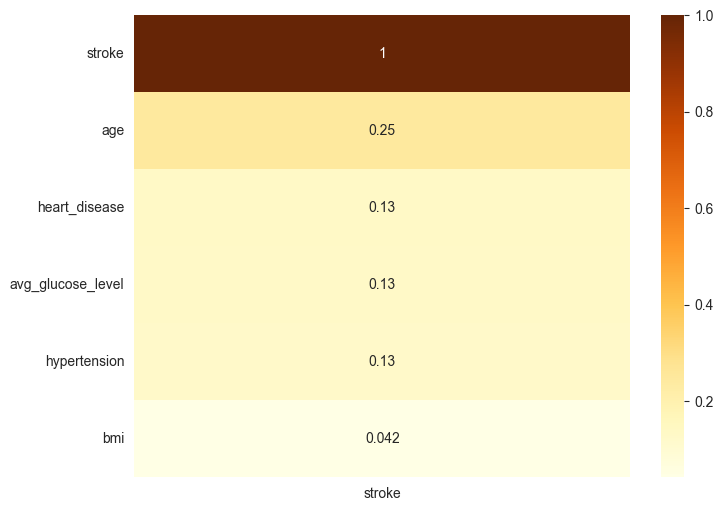

In [853]:
plt.figure(figsize=(8,6))
sns.heatmap(num_cols.corr()[['stroke']].sort_values(by='stroke',ascending=False),annot=True, cmap = 'YlOrBr')

The Pearson correlation coefficient showed that there is no linear dependence in our data. Therefore, the problem of multicollenarity will not affect us. Age is a column that correlates somehow with all other signs

In [854]:
# We will evaluate the correlation of categorical features with the target using the Kramer correlation coefficientX = data.drop('stroke', axis=1)
y = data['stroke']

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

for column in cat_cols:
     print(f'The correlation of {column} together with the target is equal to:', round(cramers_v(cat_cols[column], y), 3))



The correlation of gender together with the target is equal to: 0.0
The correlation of ever_married together with the target is equal to: 0.106
The correlation of work_type together with the target is equal to: 0.094
The correlation of Residence_type together with the target is equal to: 0.004
The correlation of smoking_status together with the target is equal to: 0.072


Kramer's correlation coefficient also showed no dependencies. However, we will look at these variables in a visual analysis. 

We see that gender does not affect the target in any way

 Most likely, there is a more complex dependency in the data

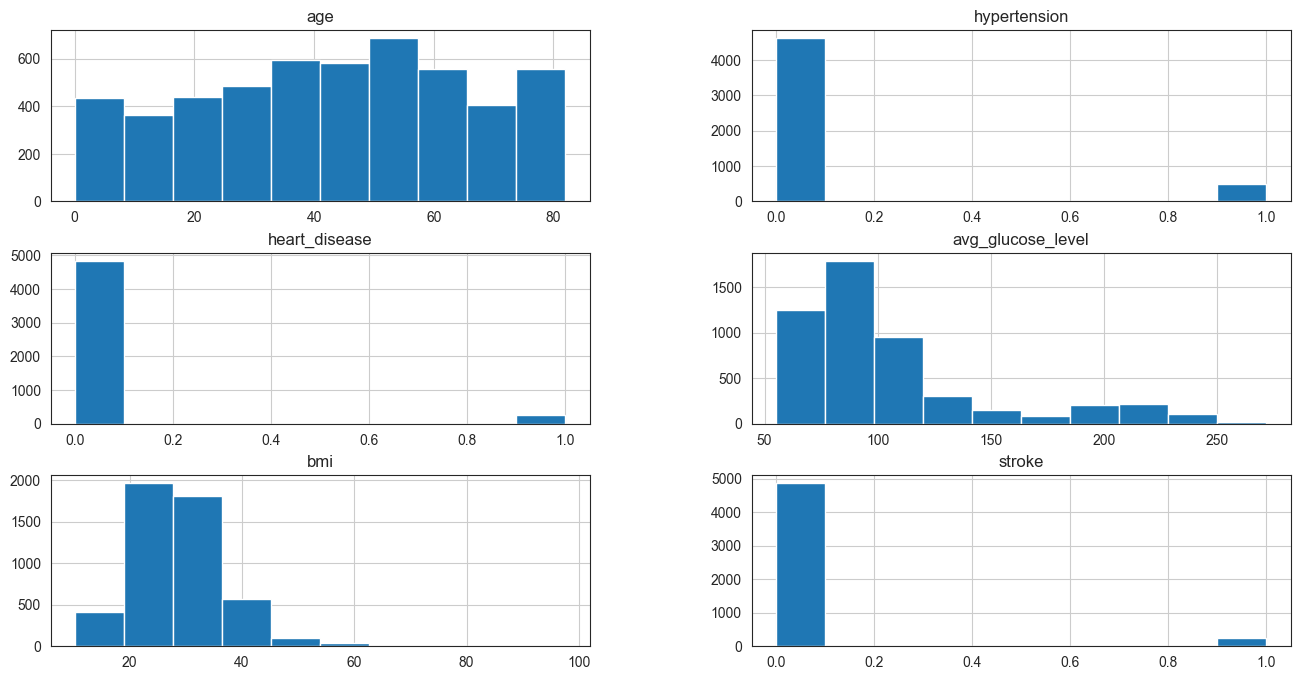

In [855]:
# Let's visualize the numerical features.
num_cols.hist(figsize=(16, 8));

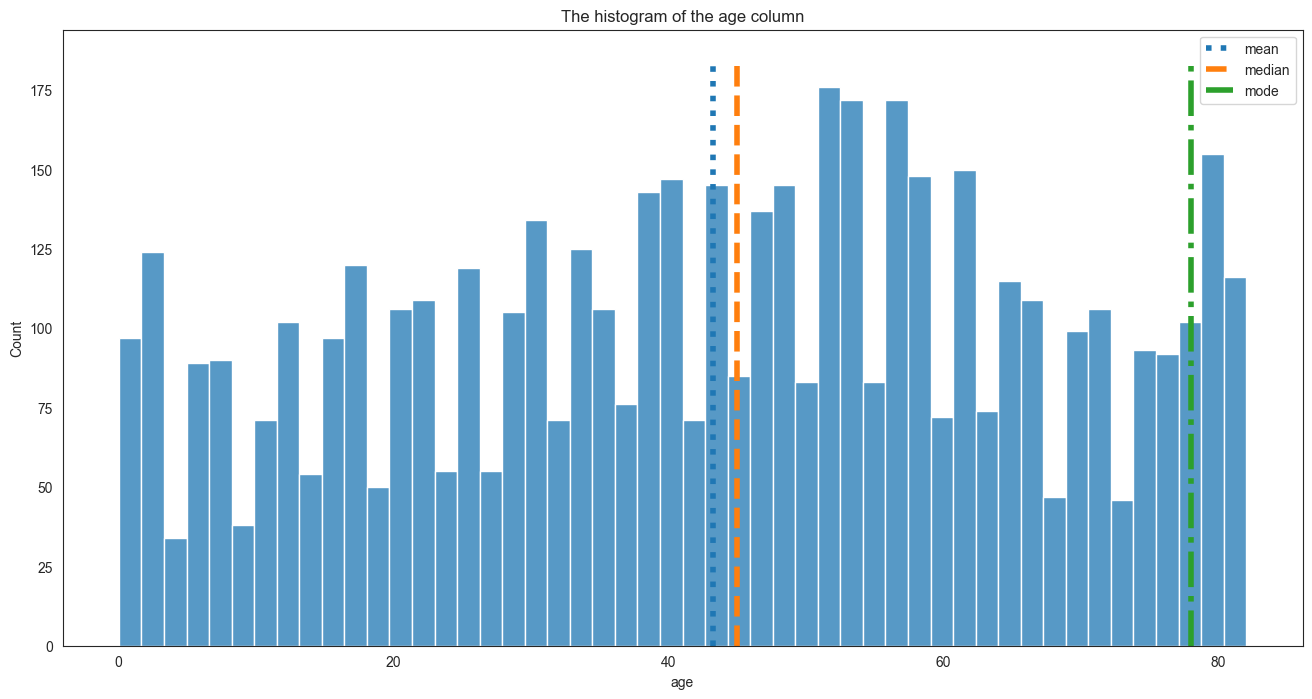

In [856]:
# Let's look at the age column
target_mean = round(data['age'].mean(), 2)
target_median = data['age'].median()
target_mode = data['age'].mode()[0]

plt.figure(figsize=(16, 8))

sns.histplot(data['age'], bins=50)

y = np.linspace(0, plt.ylim()[1], 2)
plt.plot([target_mean] * 2, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 2, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 2, y, label='mode', linestyle='-.', linewidth=4)

plt.title('The histogram of the age column')
plt.legend()
plt.show()


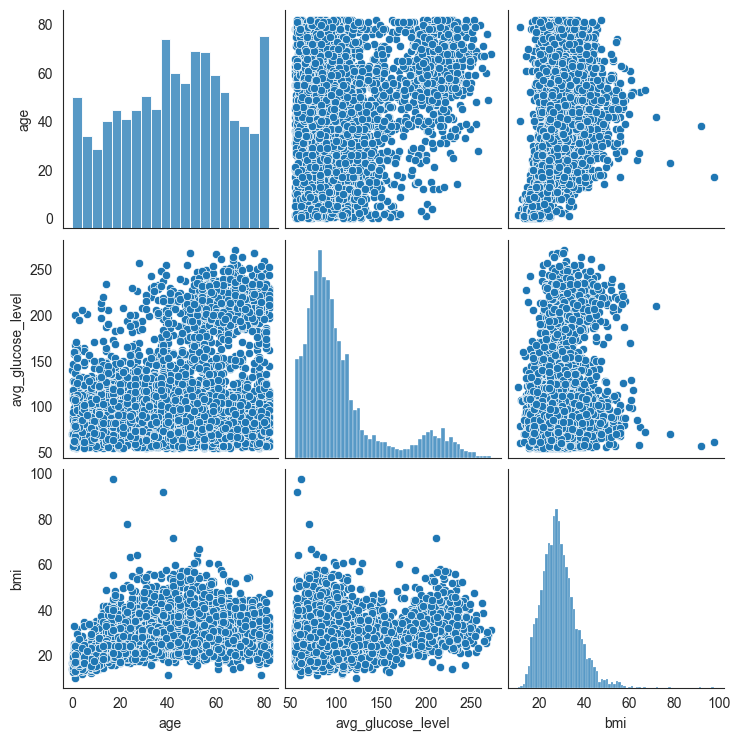

In [857]:
# Let's discard the binary signs and look at the relationships between the other real columns
for_pairplot = data[['age', 'avg_glucose_level', 'bmi']]
sns.pairplot(for_pairplot);


The graph showed that there really is no relationship between the data. The maximum is a weakly expressed linear dependence

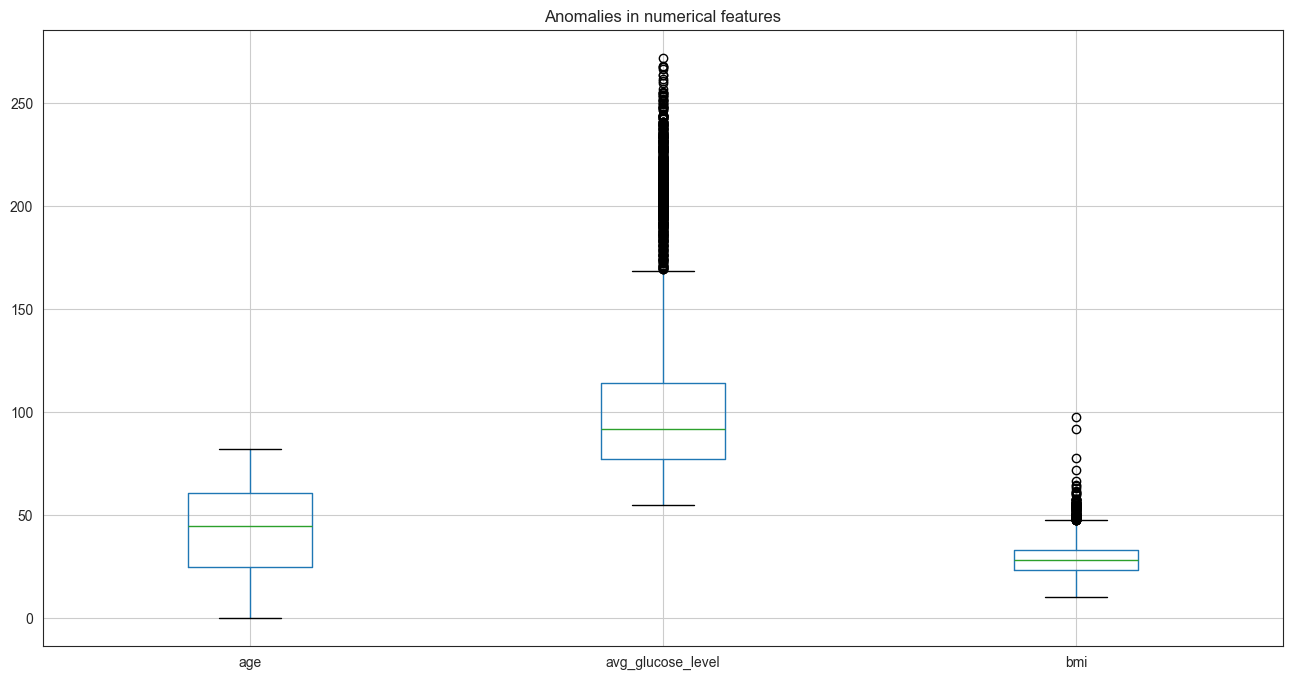

In [858]:
# Let's look at the anomalies
for_pairplot.boxplot(figsize=(16, 8))
plt.title('Anomalies in numerical features');

The boxes with moustaches showed that the anomalies are present in only two columns. Despite the fact that the initial analysis indicated some anomalies in the age column, visualization showed the opposite

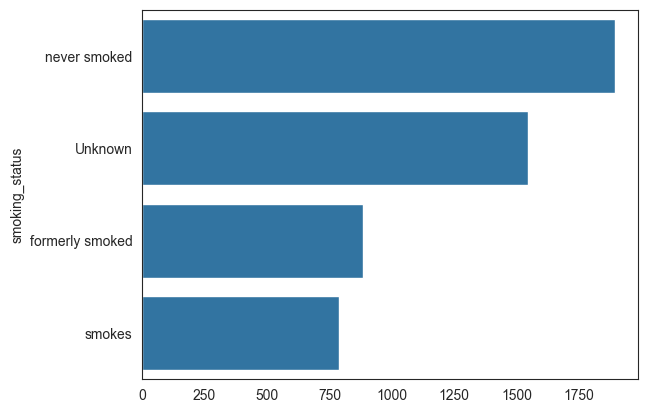

In [859]:
smoke = cat_cols['smoking_status'].value_counts()
sns.barplot(x=smoke.values, y=smoke.index);

We see a large number of unknown data`

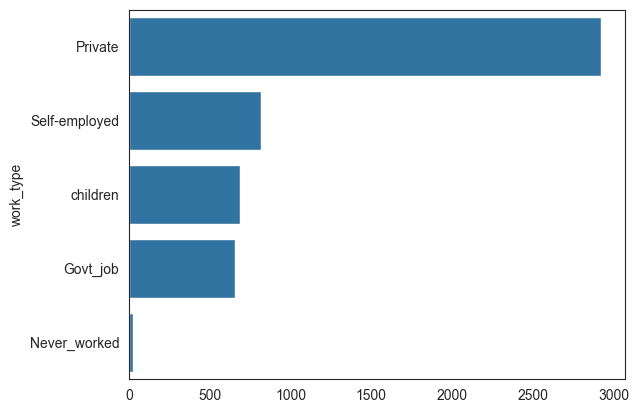

In [860]:
work = cat_cols['work_type'].value_counts()
sns.barplot(x=work.values, y=work.index);

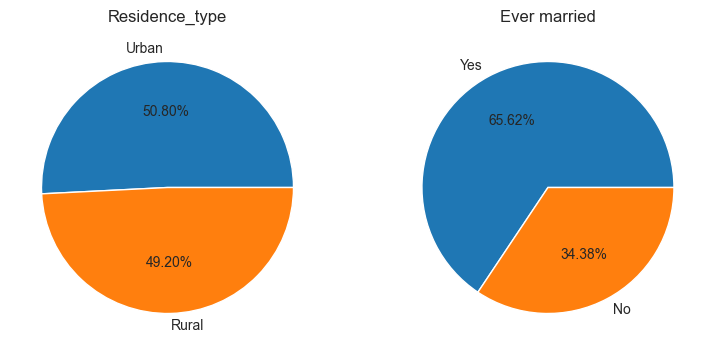

In [861]:

residence = cat_cols['Residence_type'].value_counts()
plt.figure(figsize=(9, 9))

plt.subplot(2, 2, 1)
plt.title('Residence_type')
plt.pie(residence.values, labels=residence.index, autopct='%.2f%%')

married = cat_cols['ever_married'].value_counts()

plt.subplot(2, 2, 2)
plt.title('Ever married')
plt.pie(married.values, labels=married.index, autopct='%.2f%%')
plt.show()

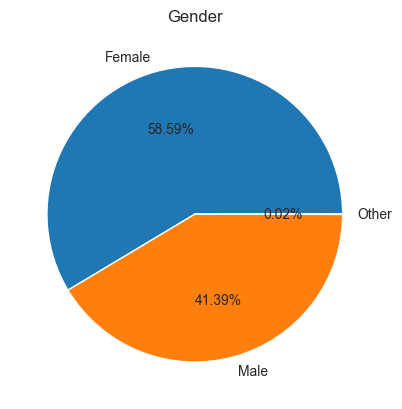

In [862]:
gender = cat_cols['gender'].value_counts()

plt.title('Gender')
plt.pie(gender.values, labels=gender.index, autopct='%.2f%%')
plt.show()

Now let's look at the relationship between attributes and target

In [863]:
# Create a new column 'age_group' with distribution by age groups
data['age_group'] = pd.cut(data['age'], bins=[0, 25, 50, 75, 100], labels=['0-25', '26-50', '51-75', '76-100'])
data.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,51-75
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,51-75
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,76-100
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,26-50
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,76-100


In [864]:
data['age_group'].value_counts()

age_group
26-50     1690
51-75     1662
0-25      1293
76-100     465
Name: count, dtype: int64

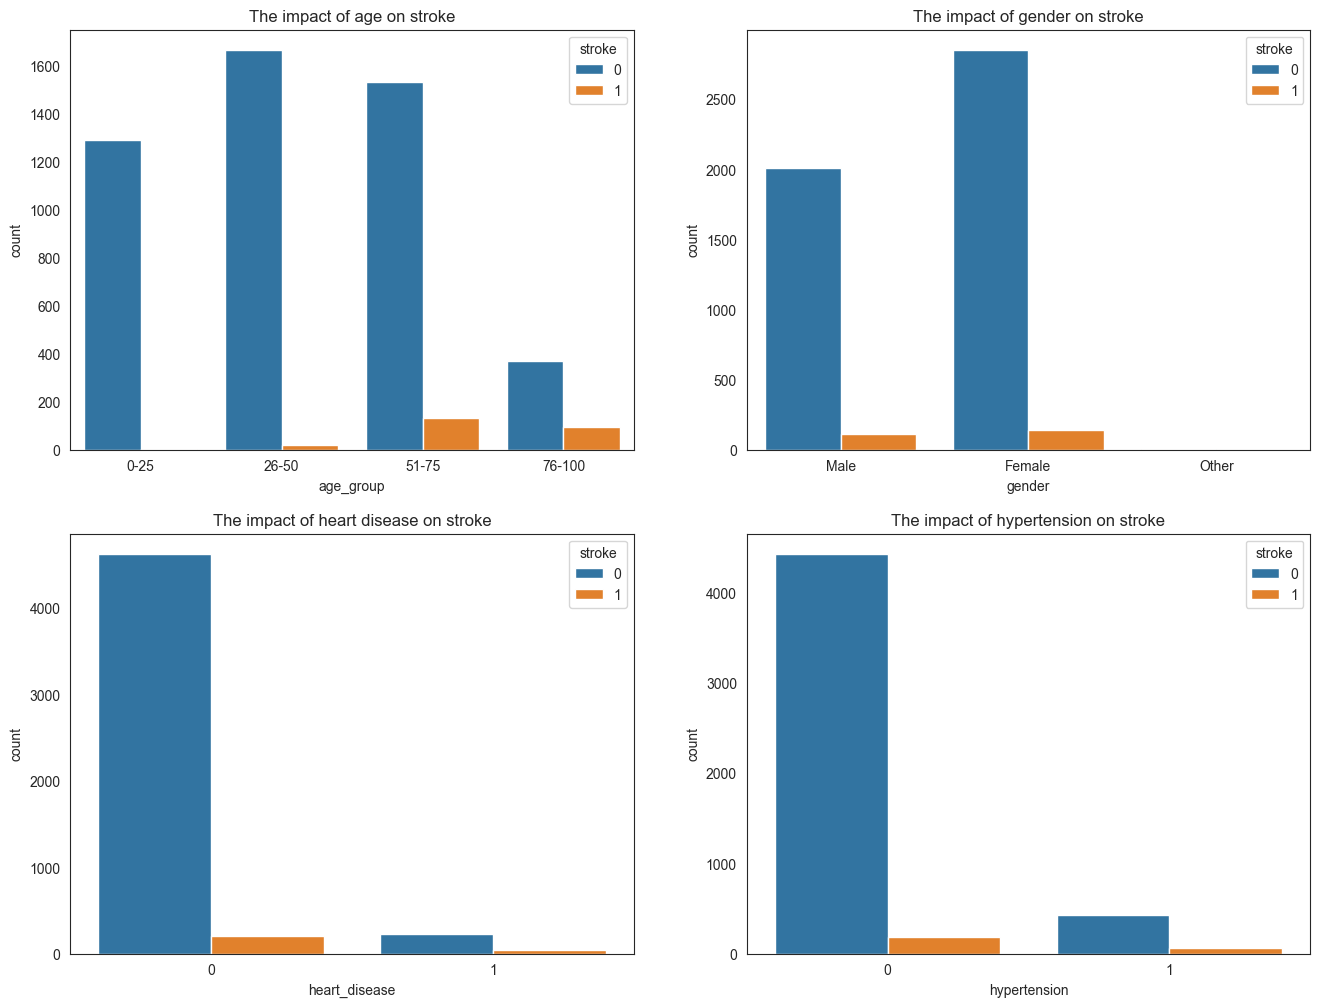

In [865]:
plt.figure(figsize=(16,12))

plt.subplot(2, 2, 1)
sns.countplot(x=data['age_group'],  hue = data['stroke'])
plt.title('The impact of age on stroke')

plt.subplot(2, 2, 2)
sns.countplot(x=data['gender'],  hue = data['stroke'])
plt.title('The impact of gender on stroke')

plt.subplot(2, 2, 3)
sns.countplot(x=data['heart_disease'],  hue = data['stroke'])
plt.title('The impact of heart disease on stroke')

plt.subplot(2, 2, 4)
sns.countplot(x=data['hypertension'],  hue = data['stroke'])
plt.title('The impact of hypertension on stroke')


plt.show()

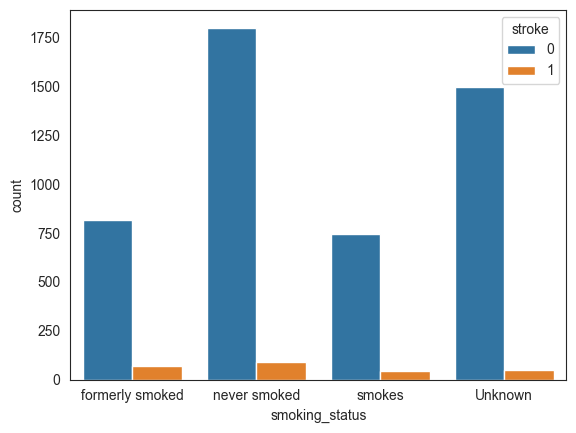

In [799]:
sns.countplot(x = data['smoking_status'], hue=data['stroke'])
plt.show()

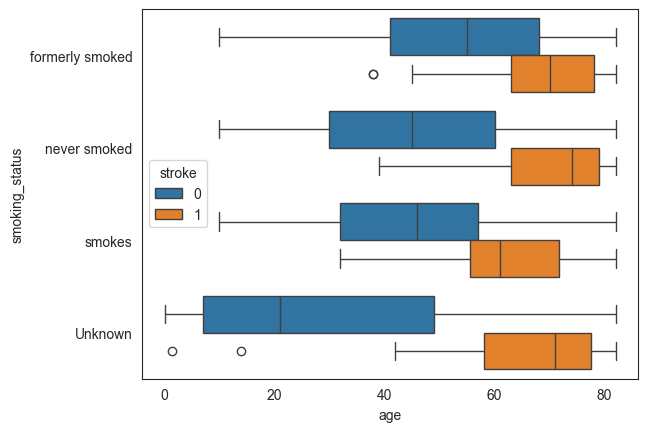

In [800]:
sns.boxplot(x = data['age'], y = data['smoking_status'], hue=data['stroke'])
plt.show()

In [801]:
data['smoking_status'].value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

In [866]:
total_people1 = data[(data['heart_disease'] == 1) & (data['hypertension'] == 1) & (data['stroke'] == 1)].shape[0]
total_people0 = data[(data['heart_disease'] == 1) & (data['hypertension'] == 1) & (data['stroke'] == 0)].shape[0]

print("The number of people with hypertension, heart disease, and stroke:", total_people1)
print("The number of people with hypertension, heart disease and without stroke:", total_people0)



The number of people with hypertension, heart disease, and stroke: 13
The number of people with hypertension, heart disease and without stroke: 51


The graphs showed that
1. Heart disease, age and hypertension affect the risk of stroke
2. Gender does not affect in any way, therefore it is a useless feature
3. The sign of smoking does not say much, because there is a lot of unknown data. Visualization shows that most people do not smoke.
4. Since there are too many unknown data in the column about smoking, we will not replace them in any way.

****
We will get the basic solution
****

 To do this, we will use CatBoost

In [803]:
X = data.drop('stroke', axis=1)
y = data['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, test_size=0.2, stratify=y)

In [804]:
# CatBoost automatically handles categorical features, so just give it the column names
cat_for_cboost = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'age_group']
cat_for_cboost

['gender',
 'ever_married',
 'work_type',
 'Residence_type',
 'smoking_status',
 'age_group']

In [805]:
base_cboost = CatBoostClassifier(loss_function='Logloss', random_state=42, cat_features=cat_for_cboost)

base_cboost.fit(X_train, y_train)

base_test_pred = base_cboost.predict(X_test)
base_train_pred = base_cboost.predict(X_train)

Learning rate set to 0.018795
0:	learn: 0.6588077	total: 18.2ms	remaining: 18.2s
1:	learn: 0.6284729	total: 36.7ms	remaining: 18.3s
2:	learn: 0.6049410	total: 59.9ms	remaining: 19.9s
3:	learn: 0.5832131	total: 82.2ms	remaining: 20.5s
4:	learn: 0.5636910	total: 87.9ms	remaining: 17.5s
5:	learn: 0.5445403	total: 107ms	remaining: 17.7s
6:	learn: 0.5194843	total: 129ms	remaining: 18.2s
7:	learn: 0.4949445	total: 150ms	remaining: 18.5s
8:	learn: 0.4761763	total: 172ms	remaining: 18.9s
9:	learn: 0.4618871	total: 179ms	remaining: 17.7s
10:	learn: 0.4457278	total: 195ms	remaining: 17.5s
11:	learn: 0.4328916	total: 203ms	remaining: 16.7s
12:	learn: 0.4208042	total: 209ms	remaining: 15.9s
13:	learn: 0.4084740	total: 222ms	remaining: 15.7s
14:	learn: 0.3976335	total: 229ms	remaining: 15.1s
15:	learn: 0.3873480	total: 236ms	remaining: 14.5s
16:	learn: 0.3770490	total: 246ms	remaining: 14.2s
17:	learn: 0.3677984	total: 256ms	remaining: 13.9s
18:	learn: 0.3575672	total: 276ms	remaining: 14.2s
19:	le

In [867]:
feature_importances = base_cboost.feature_importances_

feature_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

top_n = 10
top_features = feature_importance_df.head(top_n)
print("Top-{} important features:".format(top_n))
top_features


Top-10 important features:


,feature,importance
2,age,25.560944
9,bmi,13.173628
0,id,12.059426
8,avg_glucose_level,10.881490
11,age_group,9.121563
10,smoking_status,7.997895
6,work_type,5.296813
1,gender,5.014368
5,ever_married,4.370340
3,hypertension,3.026872


In [807]:
results_df = pd.DataFrame(columns=['Model', 'F1 Score', 'Recall', 'AUC', 'Accuracy'])

# Function to calculate metrics and add results to a dataframe
def add_model_results(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    accuracy = model.score(X_test, y_test)
    
    results_df.loc[len(results_df)] = {'Model': model_name, 'F1 Score': f1, 'Recall': recall, 'AUC': auc, 'Accuracy': accuracy}

add_model_results(base_cboost, X_test, y_test, 'Base CatBoost')

results_df


,Model,F1 Score,Recall,AUC,Accuracy
0,Base CatBoost,0.039216,0.02,0.51,0.952055


Conclusions on the baseline model:

In this task, the recall of the first class is very important. We need to identify as many cases as possible where a person may have a stroke.

Due to the imbalanced classes, the metrics for the first class are very poor, especially on the test set.

****
Feature engineering
****

In [808]:
# Delete the id and gender columns
data.drop(['gender', 'id'], axis=1, inplace=True)

data.head(5)



,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,51-75
1,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,51-75
2,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,76-100
3,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,26-50
4,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,76-100


In [809]:
data.isna().sum()

age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
age_group              0
dtype: int64

In [810]:
# We will find anomalies by finding quantiles. 
# Let's make them softer than the first and third quantiles, since our model should be able to determine the predisposition to stroke even on such data

class RemoveOutliers(BaseEstimator, TransformerMixin):
    
    ''' Класс для поиска выбросов '''

    def __init__(self):

        self.lefts = {}
        self.rights = {}
        self.medians = None

    def fit(self, X, y=None):

        self.medians = X.median()

        X = X.copy()
        for col in X.columns:
            q3 = np.quantile(X[col], q=0.85)
            q1 = np.quantile(X[col], q=0.15)
            iqr = 1.5 * (q3 - q1)
            self.lefts[col] = q1 - iqr
            self.rights[col] = q3 + iqr
        return self

    def transform(self, X, y=None):
        X = X.copy()

        for col in X.columns:
          
          X.loc[~(X[col].between(self.lefts[col], self.rights[col])), col] = self.medians[col]
        return X

In [811]:
# We will transfer from the categorical column to the numerical one manually
data['age_group'].replace(
    {'0-25': 0, '26-50': 1, '51-75': 2, '76-100': 3},
      inplace=True)


In [812]:
# Fill in the gaps in the bmi column. We will take the average value by age
data['bmi'] = data['bmi'].fillna(data.groupby('age')['bmi'].transform('mean'))

In [813]:
# Prepare the columns for transformation
num_cols_for_transform = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
cat_cols_for_transform = ['ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [814]:
num_pipe = make_pipeline(
    # pipeline for processing numerical features
    RemoveOutliers(),
    StandardScaler()
)

cat_pipe = make_pipeline(
    # pipeline for processing categorical features
    OneHotEncoder(handle_unknown="ignore")
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols_for_transform),
        ("cat", cat_pipe, cat_cols_for_transform),
    ]
)

X_train_transform = preprocessor.fit_transform(X_train)
X_test_transform = preprocessor.transform(X_test)

X_train_transform.shape

(4088, 18)

In [815]:
X_train_transform = pd.DataFrame(X_train_transform)
X_train_transform

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.205661,0.0,0.0,-0.822340,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-1.254901,0.0,0.0,0.363879,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.046590,0.0,0.0,0.099305,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.028623,0.0,0.0,-0.907325,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-1.299160,0.0,0.0,-0.528692,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,0.072883,0.0,0.0,-0.293417,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4084,-1.210641,0.0,0.0,0.167518,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4085,0.781034,0.0,0.0,-0.611218,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4086,-0.546750,0.0,0.0,-0.714095,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


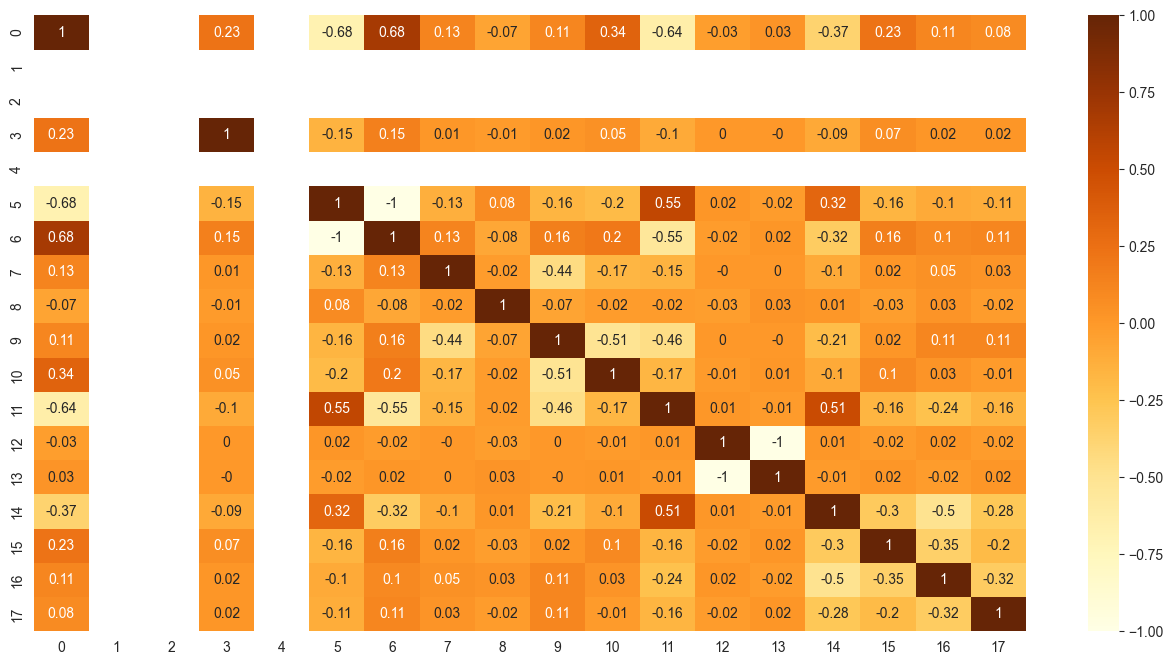

In [816]:
# Let's check the correlation again
corr = X_train_transform.corr().round(2)
plt.figure(figsize=(16, 8))
sns.heatmap(corr, annot = True, cmap = 'YlOrBr');

We see that there are signs that correlate with each other, but there is no strong correlation that can interfere with the model

I set myself the following task:

I need to identify as many cases of stroke probability as possible. Therefore, I will have the following key metrics

1. F1 Score (To score both zero and first class)
2. Recall (Important for the first class)
3. Macro recall (To determine the average recall)

In [817]:
#Let's train several models
svm_model = SVC(random_state=42)
cboost_model = CatBoostClassifier(random_state=42)
lgbm_model = LGBMClassifier(random_state=42)
logreg_model = LogisticRegression(random_state=42)
rfc_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
gbc_model = GradientBoostingClassifier(random_state=42)
models = [svm_model, rfc_model, xgb_model, gbc_model, cboost_model, lgbm_model, logreg_model]

for clf in models:
    clf.fit(X_train_transform, y_train)
    add_model_results(clf, X_test_transform, y_test, f'{clf}')

Learning rate set to 0.018795
0:	learn: 0.6603096	total: 2.02ms	remaining: 2.02s
1:	learn: 0.6332664	total: 3.89ms	remaining: 1.94s
2:	learn: 0.6092600	total: 5.57ms	remaining: 1.85s
3:	learn: 0.5880519	total: 6.77ms	remaining: 1.69s
4:	learn: 0.5592938	total: 8.25ms	remaining: 1.64s
5:	learn: 0.5360518	total: 9.95ms	remaining: 1.65s
6:	learn: 0.5118985	total: 11.8ms	remaining: 1.67s
7:	learn: 0.4944637	total: 13.5ms	remaining: 1.68s
8:	learn: 0.4751736	total: 15.5ms	remaining: 1.7s
9:	learn: 0.4609384	total: 16.7ms	remaining: 1.65s
10:	learn: 0.4472888	total: 17.9ms	remaining: 1.61s
11:	learn: 0.4300847	total: 19.7ms	remaining: 1.62s
12:	learn: 0.4143570	total: 21.4ms	remaining: 1.63s
13:	learn: 0.3987478	total: 23.2ms	remaining: 1.63s
14:	learn: 0.3874009	total: 24.9ms	remaining: 1.64s
15:	learn: 0.3747855	total: 26.7ms	remaining: 1.64s
16:	learn: 0.3645414	total: 28.1ms	remaining: 1.62s
17:	learn: 0.3525966	total: 30ms	remaining: 1.64s
18:	learn: 0.3414547	total: 31.9ms	remaining: 1

In [818]:
results_df.sort_values(by='F1 Score', ascending=False)


,Model,F1 Score,Recall,AUC,Accuracy
2,RandomForestClassifier(random_state=42),0.103448,0.06,0.527428,0.949119
3,"XGBClassifier(base_score=None, booster=None, c...",0.093750,0.06,0.524342,0.943249
6,LGBMClassifier(random_state=42),0.071429,0.04,0.517942,0.949119
0,Base CatBoost,0.039216,0.02,0.510000,0.952055
1,SVC(random_state=42),0.000000,0.00,0.500000,0.951076
4,GradientBoostingClassifier(random_state=42),0.000000,0.00,0.498971,0.949119
5,<catboost.core.CatBoostClassifier object at 0x...,0.000000,0.00,0.498457,0.948141
7,LogisticRegression(random_state=42),0.000000,0.00,0.500000,0.951076


We see bad results. Most likely, the imbalance of classes in the target is to blame

In [819]:
# Let's resolve this issue. Apply SMOTE
smote = SMOTE(random_state=42)
X_smote_train, y_smote_train = smote.fit_resample(X_train_transform, y_train)


unique, counts = np.unique(y_smote_train, return_counts=True)
class_counts = dict(zip(unique, counts))
print(class_counts)


{0: 3889, 1: 3889}


In [820]:
X_smote_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.205661,0.0,0.0,-0.822340,0.0,0.000000,1.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-1.254901,0.0,0.0,0.363879,0.0,1.000000,0.000000,0.000000,0.0,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.046590,0.0,0.0,0.099305,0.0,0.000000,1.000000,0.000000,0.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.028623,0.0,0.0,-0.907325,0.0,0.000000,1.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-1.299160,0.0,0.0,-0.528692,0.0,1.000000,0.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7773,1.191050,0.0,0.0,-0.059899,0.0,0.000000,1.000000,0.000000,0.0,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7774,0.742841,0.0,0.0,2.358075,0.0,0.215729,0.784271,0.215729,0.0,0.784271,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7775,0.336499,0.0,0.0,-0.097562,0.0,0.000000,1.000000,0.000000,0.0,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7776,0.722217,0.0,0.0,0.157043,0.0,0.000000,1.000000,0.000000,0.0,0.000000,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [821]:
#Let's train models on new data
svm_model = SVC(random_state=42)
cboost_model = CatBoostClassifier(random_state=42)
lgbm_model = LGBMClassifier(random_state=42)
logreg_model = LogisticRegression(random_state=42)
rfc_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
gbc_model = GradientBoostingClassifier(random_state=42)
models = [svm_model, rfc_model, xgb_model, gbc_model, cboost_model, lgbm_model, logreg_model]

for clf in models:
    clf.fit(X_smote_train, y_smote_train)
    add_model_results(clf, X_test_transform, y_test, f'SMOTE-{clf}')

Learning rate set to 0.024736
0:	learn: 0.6746866	total: 2.98ms	remaining: 2.98s
1:	learn: 0.6590663	total: 5.6ms	remaining: 2.79s
2:	learn: 0.6451879	total: 8.17ms	remaining: 2.71s
3:	learn: 0.6279521	total: 11ms	remaining: 2.75s
4:	learn: 0.6131681	total: 13.6ms	remaining: 2.71s
5:	learn: 0.6032681	total: 16ms	remaining: 2.65s
6:	learn: 0.5915710	total: 18.7ms	remaining: 2.66s
7:	learn: 0.5818636	total: 21.5ms	remaining: 2.66s
8:	learn: 0.5723475	total: 24.7ms	remaining: 2.72s
9:	learn: 0.5637262	total: 28.8ms	remaining: 2.85s
10:	learn: 0.5548462	total: 32.5ms	remaining: 2.92s
11:	learn: 0.5465631	total: 36ms	remaining: 2.96s
12:	learn: 0.5392365	total: 39.6ms	remaining: 3.01s
13:	learn: 0.5326287	total: 43.5ms	remaining: 3.07s
14:	learn: 0.5257462	total: 47ms	remaining: 3.08s
15:	learn: 0.5182097	total: 50.5ms	remaining: 3.1s
16:	learn: 0.5120700	total: 53.9ms	remaining: 3.12s
17:	learn: 0.5073862	total: 57.1ms	remaining: 3.12s
18:	learn: 0.5022730	total: 60.4ms	remaining: 3.12s
19

In [822]:
results_df.sort_values(by='F1 Score', ascending=False)


,Model,F1 Score,Recall,AUC,Accuracy
11,SMOTE-GradientBoostingClassifier(random_state=42),0.239130,0.66,0.730720,0.794521
14,SMOTE-LogisticRegression(random_state=42),0.234234,0.78,0.764486,0.750489
13,SMOTE-LGBMClassifier(random_state=42),0.222222,0.18,0.578683,0.938356
10,"SMOTE-XGBClassifier(base_score=None, booster=N...",0.220339,0.26,0.601708,0.909980
9,SMOTE-RandomForestClassifier(random_state=42),0.193548,0.30,0.603704,0.877691
12,SMOTE-<catboost.core.CatBoostClassifier object...,0.189474,0.18,0.571481,0.924658
8,SMOTE-SVC(random_state=42),0.180685,0.58,0.665514,0.742661
2,RandomForestClassifier(random_state=42),0.103448,0.06,0.527428,0.949119
3,"XGBClassifier(base_score=None, booster=None, c...",0.093750,0.06,0.524342,0.943249
6,LGBMClassifier(random_state=42),0.071429,0.04,0.517942,0.949119


In [823]:
print('Test:', classification_report(y_test, gbc_model.predict(X_test_transform)))


Test:               precision    recall  f1-score   support

           0       0.98      0.80      0.88       972
           1       0.15      0.66      0.24        50

    accuracy                           0.79      1022
   macro avg       0.56      0.73      0.56      1022
weighted avg       0.94      0.79      0.85      1022



The table showed that the quality has improved a lot.

 Logistic regression and gradient boosting showed the best result. Despite the fact that logistic regression has the best result on recall, let's test the hypothesis that by spending time and resources on tuning gradient boosting, we will achieve the best result

In [824]:



param_space = {
    'n_estimators': Integer(100, 300),  
    'learning_rate': Real(0.01, 0.2, 'log-uniform'), 
    'max_depth': Integer(3, 5), 
    'subsample': Real(0.8, 1.0), 
    'min_samples_split': Integer(2, 5)  
}

# Setting up Bayesian optimization using cross validation
bayes_gbc = BayesSearchCV(
    estimator=gbc_model, 
    search_spaces=param_space, 
    n_iter=32, 
    cv=3, 
    scoring='recall',  
    n_jobs=-1, 
    verbose=2, 
    random_state=42
)

bayes_gbc.fit(X_smote_train, y_smote_train)

add_model_results(bayes_gbc, X_test_transform, y_test, 'Bayes_GBC')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [825]:
param_space = {
    'n_estimators': Integer(100, 300),  
    'learning_rate': Real(0.01, 0.2, 'log-uniform'), 
    'max_depth': Integer(3, 5),  
    'subsample': Real(0.8, 1.0)  
}

bayes_cboost = BayesSearchCV(
    estimator=cboost_model, 
    search_spaces=param_space, 
    n_iter=32, 
    cv=3, 
    scoring='recall',  
    n_jobs=-1, 
    verbose=2, 
    random_state=42
)
CatBoostClassifier()

bayes_cboost.fit(X_smote_train, y_smote_train)

add_model_results(bayes_cboost, X_test_transform, y_test, 'Bayes_Cboost')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [826]:
param_space = {
    'n_estimators': Integer(100, 300),
    'learning_rate': Real(0.01, 0.2, 'log-uniform'), 
    'max_depth': Integer(3, 5), 
    'subsample': Real(0.8, 1.0),  
    'min_samples_split': Integer(2, 5) 
}

bayes_xgb = BayesSearchCV(
    estimator=xgb_model, 
    search_spaces=param_space, 
    n_iter=32, 
    cv=3, 
    scoring='recall',  
    n_jobs=-1, 
    verbose=2, 
    random_state=42
)

bayes_xgb.fit(X_smote_train, y_smote_train)

add_model_results(bayes_xgb, X_test_transform, y_test, 'Bayes_XGB')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [827]:
results_df.sort_values(by='F1 Score', ascending=False)

,Model,F1 Score,Recall,AUC,Accuracy
15,Bayes_GBC,0.242991,0.78,0.770658,0.780000
17,Bayes_XGB,0.240602,0.64,0.725350,0.640000
16,Bayes_Cboost,0.239130,0.44,0.662387,0.440000
11,SMOTE-GradientBoostingClassifier(random_state=42),0.239130,0.66,0.730720,0.794521
14,SMOTE-LogisticRegression(random_state=42),0.234234,0.78,0.764486,0.750489
13,SMOTE-LGBMClassifier(random_state=42),0.222222,0.18,0.578683,0.938356
10,"SMOTE-XGBClassifier(base_score=None, booster=N...",0.220339,0.26,0.601708,0.909980
9,SMOTE-RandomForestClassifier(random_state=42),0.193548,0.30,0.603704,0.877691
12,SMOTE-<catboost.core.CatBoostClassifier object...,0.189474,0.18,0.571481,0.924658
8,SMOTE-SVC(random_state=42),0.180685,0.58,0.665514,0.742661


In [828]:
feature_importances = gbc_model.feature_importances_

feature_importance_df = pd.DataFrame({'feature': X_smote_train.columns, 'importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

top_n = 10
top_features = feature_importance_df.head(top_n)
print("Top-{} important features:".format(top_n))
top_features


Топ-10 важных признаков:


,feature,importance
0,0,0.849329
3,3,0.042908
10,10,0.014965
7,7,0.014374
9,9,0.014257
17,17,0.012630
16,16,0.010266
15,15,0.009371
14,14,0.008138
6,6,0.005843


<Axes: >

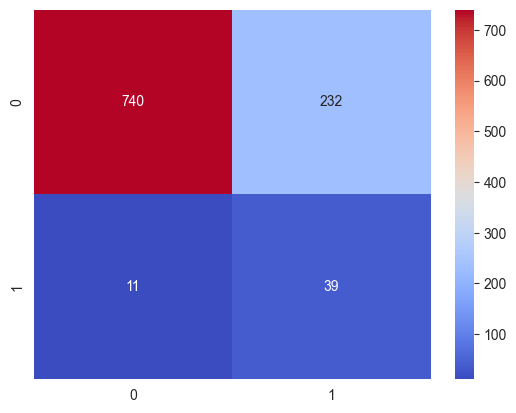

In [829]:
mod = metrics.confusion_matrix(y_test, bayes_gbc.predict(X_test_transform))
sns.heatmap(mod,annot=True,cmap='coolwarm', fmt='d')

In [830]:
print(round(recall_score(y_test, bayes_gbc.predict(X_test_transform), average='macro'), 3))

0.771


In [831]:
print(classification_report(y_test, bayes_gbc.predict(X_test_transform)))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86       972
           1       0.14      0.78      0.24        50

    accuracy                           0.76      1022
   macro avg       0.56      0.77      0.55      1022
weighted avg       0.94      0.76      0.83      1022



Let's try to train the model on two grounds

In [832]:
new_x_train = X_smote_train[[0, 3]]
new_x_train

,0,3
0,0.205661,-0.822340
1,-1.254901,0.363879
2,1.046590,0.099305
3,0.028623,-0.907325
4,-1.299160,-0.528692
...,...,...
7773,1.191050,-0.059899
7774,0.742841,2.358075
7775,0.336499,-0.097562
7776,0.722217,0.157043


In [833]:
bayes_gbc.fit(new_x_train, y_smote_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
              n_iter=32, n_jobs=-1, random_state=42, scoring='recall',
              search_spaces={'learning_rate': Real(low=0.01, high=0.2, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=5, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=5, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=300, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.8, high=1.0, prior='uniform', transform='normalize')},
              verbose=2)

In [834]:
X_test_transform = pd.DataFrame(X_test_transform)
new_x_test = X_test_transform[[0, 3]]
new_x_test
print(classification_report(y_test, bayes_gbc.predict(new_x_test)))

              precision    recall  f1-score   support

           0       0.98      0.76      0.86       972
           1       0.14      0.76      0.24        50

    accuracy                           0.76      1022
   macro avg       0.56      0.76      0.55      1022
weighted avg       0.94      0.76      0.83      1022



<Axes: >

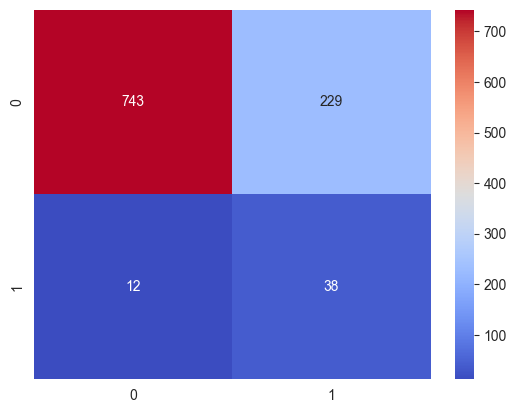

In [773]:
mod = metrics.confusion_matrix(y_test, bayes_gbc.predict(new_x_test))
sns.heatmap(mod,annot=True,cmap='coolwarm', fmt='d')

****
Conclusions
****

1. In the process of improving the quality of the CatBoost model, the following steps were performed:
 - Treatment of anomalies by replacing them with the median value.
 - Application of categorical feature encoding using One-Hot Encoding (OHE).
 - Balancing classes using the Synthetic Minority Over-sampling Technique (SMOTE) method.
 - Applying Bayesian optimization to some models to improve results.

2. Gradient boosting from the scikit-learn library turned out to be the most effective, to which Bayes optimization was applied.

3. Age plays a key role in predicting the target variable.

The hypothesis about gradient boosting has been confirmed. 

 We achieved a good result with macro recall - 0.77. The model was able to identify 39/50 cases.